In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import skimage.io as skio
from skimage.transform import resize
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
import random
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import xml.etree.ElementTree as ET 

In [2]:
# mount google drive and zip the data file from there 
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/ibug_300W_large_face_landmark_dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: helen/trainset/2167180876_1_mirror.jpg  
  inflating: helen/trainset/2167874246_1.jpg  
  inflating: helen/trainset/2167874246_1_mirror.jpg  
  inflating: helen/trainset/2168442441_1.jpg  
  inflating: helen/trainset/2168442441_1_mirror.jpg  
  inflating: helen/trainset/2168442533_1.jpg  
  inflating: helen/trainset/2168442533_1_mirror.jpg  
  inflating: helen/trainset/2168477255_1.jpg  
  inflating: helen/trainset/2168477255_1_mirror.jpg  
  inflating: helen/trainset/2169267682_1.jpg  
  inflating: helen/trainset/2169267682_1_mirror.jpg  
  inflating: helen/trainset/2169268854_1.jpg  
  inflating: helen/trainset/2169268854_1_mirror.jpg  
  inflating: helen/trainset/2169601621_1.jpg  
  inflating: helen/trainset/2169601621_1_mirror.jpg  
  inflating: helen/trainset/2170250827_1.jpg  
  inflating: helen/trainset/2170250827_1_mirror.jpg  
  inflating: helen/trainset/2170402460_1.jpg  
  inflating: helen/trainset/2170402460_1

In [3]:
# example code given to load data
tree = ET.parse('/content/labels_ibug_300W_train.xml')
root = tree.getroot()

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(filename.attrib['file'])
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

In [4]:
class FaceKeypointDataset(Dataset):

    def __init__(self, images, landmarks, boxes, transform=None):
        self.images_filename = images
        self.landmarks = landmarks
        self.boxes = boxes
        self.transform = transform
        
    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = skio.imread(self.images_filename[idx], as_gray=True)
        landmark = self.landmarks[idx]
        box = self.boxes[idx]
        
        sample = {"image": image, "landmarks": landmark, "box": box}

        if self.transform:
            sample = self.transform(sample)

        return sample

# crop the image by the bonding box given and update the landmarks
class Cropping(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        im_h, im_w = image.shape[:2]
        left, top, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        # handle negative bonding box values
        left = max(0, left)
        top = max(0, top)

        image_cropped = image[top:top+h, left:left+w]

        landmarks_cropped = landmarks.copy()
        landmarks_cropped -= [left, top]

        return {"image": image_cropped, "landmarks": landmarks_cropped, "box": box}

# resize the image and update the landmarks
class Resize(object):
    def __init__(self, h, w):
        self.height = h
        self.width = w
    
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        h, w = image.shape[:2]

        landmarks[:, 0] *= self.width / w
        landmarks[:, 1] *= self.height / h

        image_resized = resize(image, (self.height, self.width))
        return {"image": image_resized, "landmarks": landmarks, "box": box}

# normalize the image pixel values
class Normalize(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        image_normalized = image.astype(np.float32) / 255 - 0.5  
        return {"image": image_normalized, "landmarks": landmarks, "box": box}

# scale the landmarks with the size of image
class ScaleLandmarks(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        landmarks[:, 0] /= 224
        landmarks[:, 1] /= 224
        landmarks = landmarks.astype(np.float32)
        return {"image": image, "landmarks": landmarks, "box": box}

# custome transform to randomly shift image and its landmarks in -10 to 10 pixel in both x and y direction
class RandomShift(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        h, w = image.shape[:2]
        im_shifted = np.zeros_like(image)
        x_shift = random.randint(-10, 10)
        y_shift = random.randint(-10, 10)
        im_shifted[max(0, y_shift):min(h, h+y_shift), 
                    max(0, x_shift):min(w, w+x_shift)] = image[max(0, -y_shift):min(h, h-y_shift),
                                                                    max(0, -x_shift):min(w, w-x_shift)]
        landmarks_shifted = landmarks.copy()
        landmarks_shifted[:, 0] += x_shift * np.ones_like(landmarks_shifted[:, 0])
        landmarks_shifted[:, 1] += y_shift * np.ones_like(landmarks_shifted[:, 1])

        return {"image": im_shifted, "landmarks": landmarks_shifted, "box": box}

# custome transform to randomly rotate image and its landmarks in -15 to 15 degree angles 
class RandomRotate(object):
    def __call__(self, sample):
        image, landmarks, box = sample["image"], sample["landmarks"], sample["box"]
        angle = random.randint(-15, 15)
        keypoints = KeypointsOnImage([Keypoint(x=pt[0], y=pt[1]) for pt in landmarks], shape = image.shape)
        seq = iaa.Sequential([
            iaa.Affine(
                rotate = angle
            )
        ])

        im_rotated, landmarks_rotated = seq(image=image, keypoints=keypoints)
        landmarks_rotated_final = np.array([[pt.x, pt.y] for pt in landmarks_rotated]).astype(np.float32)
        return {"image": im_rotated, "landmarks": landmarks_rotated_final, "box": box}

In [5]:
# set the seed for randomness
torch.manual_seed(1205)
random.seed(1205)

training_num = int(0.8 * len(img_filenames))
ts = transforms.Compose([Cropping(), Resize(224, 224), RandomShift(), RandomRotate(), ScaleLandmarks(), Normalize()])
training_dataset = FaceKeypointDataset(img_filenames[:training_num], landmarks[:training_num], bboxes[:training_num], transform=ts)
validation_dataset = FaceKeypointDataset(img_filenames[training_num:], landmarks[training_num:], bboxes[training_num:], transform=ts)

# create dataloaders, using batch size of 32
BATCH_SIZE = 32
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 2)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 2)


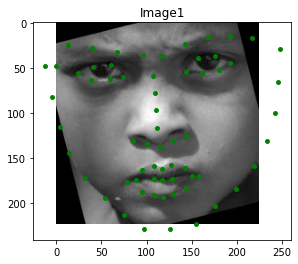

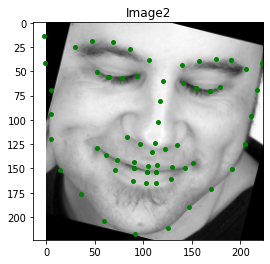

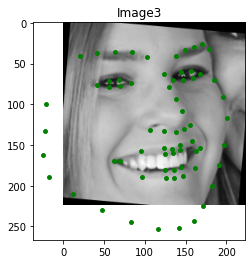

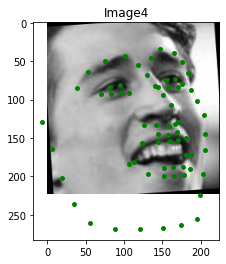

In [6]:
# sampled the first 4 images to check if the transforms work
for i, sample_batched in enumerate(training_dataloader):
  images, landmarks_batched = sample_batched["image"], sample_batched["landmarks"]
  for j in range(4):
    plt.figure()
    plt.imshow(images[j], cmap="gray")
    plt.title("Image{}".format(j + 1))
    plt.scatter(landmarks_batched[j, :, 0] * 224, landmarks_batched[j, :, 1] * 224, s=15, c="green")
    plt.savefig("/sampled_img_{}.jpg".format(j + 1))
    plt.close()
    
  break

In [10]:
# modify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

# import pretrained resnet18 as suggested and modify the first and the last layer
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
resnet18.fc = nn.Linear(512, 68 * 2, bias=True)
resnet18 = resnet18.to(device)
print(resnet18)

Using device cuda
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [11]:
# set parameters
lr = 0.0001
epochs = 25

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr, weight_decay=5e-7)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

training_loss = []
validation_loss = []

resnet18.train()
for epoch in range(epochs):
  losses = []
  for sample_batched in training_dataloader:
    optimizer.zero_grad()
    x, y = sample_batched["image"].to(device), sample_batched["landmarks"].to(device)
    x = x.unsqueeze(1)
    pred = resnet18(x)
    pred = torch.reshape(pred, (pred.shape[0], 68, 2))
    loss = criterion(pred, y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  training_loss.append(np.mean(losses))
  scheduler.step()

  # evaluate validation loss
  with torch.no_grad():
    resnet18.eval()

    losses = []
    for sample_batched in validation_dataloader:
        x, y = sample_batched["image"].to(device), sample_batched["landmarks"].to(device)
        x = x.unsqueeze(1)
        pred = resnet18(x)
        pred = torch.reshape(pred, (pred.shape[0], 68, 2))
        loss = criterion(pred, y)
        losses.append(loss.item())
    validation_loss.append(np.mean(losses))
    resnet18.train()
  print("epoch{} finished, training_loss: {}, validation_loss: {}.".format(epoch + 1, training_loss[epoch], validation_loss[epoch]))


epoch1 finished, training_loss: 0.027717128252432107, validation_loss: 0.01571355837707718.
epoch2 finished, training_loss: 0.003256101039946525, validation_loss: 0.009094337134488992.
epoch3 finished, training_loss: 0.002444005717696276, validation_loss: 0.007684901888881411.
epoch4 finished, training_loss: 0.0020868785827125084, validation_loss: 0.012139755700315748.
epoch5 finished, training_loss: 0.0018507027691843623, validation_loss: 0.00962826020882598.
epoch6 finished, training_loss: 0.0016472579898803444, validation_loss: 0.0056477614700616826.
epoch7 finished, training_loss: 0.0015495350357133918, validation_loss: 0.006822362264973067.
epoch8 finished, training_loss: 0.00152327332605223, validation_loss: 0.005250660702586174.
epoch9 finished, training_loss: 0.0014538955818973259, validation_loss: 0.007527365426843365.
epoch10 finished, training_loss: 0.0014270861200224273, validation_loss: 0.0014703727792948484.
epoch11 finished, training_loss: 0.0013722482166660134, validati

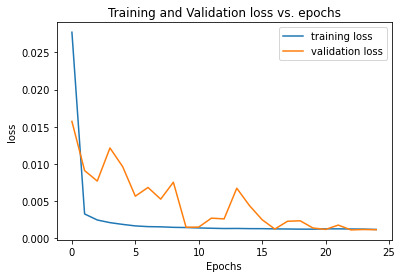

In [12]:
# plot the training and validation loss
plt.figure()
plt.plot(range(epochs), training_loss, label="training loss")
plt.plot(range(epochs), validation_loss, label="validation loss")
plt.title("Training and Validation loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/part3_loss.jpg")

In [13]:
# save the model
torch.save(resnet18.state_dict(), "/resnet18_for_part3.pt")

In [14]:
# Dateset and helper functions for test dataset: remove landmarks field
class FaceKeypointTestDataset(Dataset):

    def __init__(self, images, boxes, transform=None):
        self.images_filename = images
        self.boxes = boxes
        self.transform = transform
        
    def __len__(self):
        return len(self.images_filename)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = skio.imread(self.images_filename[idx], as_gray=True)
        box = self.boxes[idx]
        
        sample = {"image": image, "box": box}

        if self.transform:
            sample = self.transform(sample)

        return sample

class CroppingTest(object):
    def __call__(self, sample):
        image, box = sample["image"], sample["box"]
        im_h, im_w = image.shape[:2]
        left, top, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        # handle negative box
        left = max(0, left)
        top = max(0, top)

        image_cropped = image[top:top+h, left:left+w]

        return {"image": image_cropped, "box": box}

class ResizeTest(object):
    def __init__(self, h, w):
        self.height = h
        self.width = w
    
    def __call__(self, sample):
        image,  box = sample["image"], sample["box"]
        h, w = image.shape[:2]

        image_resized = resize(image, (self.height, self.width))
        return {"image": image_resized, "box": box}


class NormalizeTest(object):
    def __call__(self, sample):
        image, box = sample["image"], sample["box"]
        image_normalized = image.astype(np.float32) / 255 - 0.5  
        return {"image": image_normalized, "box": box}

In [15]:
!wget https://inst.eecs.berkeley.edu/~cs194-26/fa22/hw/proj5/labels_ibug_300W_test_parsed.xml

--2022-11-09 11:34:18--  https://inst.eecs.berkeley.edu/~cs194-26/fa22/hw/proj5/labels_ibug_300W_test_parsed.xml
Resolving inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)... 128.32.42.199
Connecting to inst.eecs.berkeley.edu (inst.eecs.berkeley.edu)|128.32.42.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131719 (129K) [text/xml]
Saving to: ‘labels_ibug_300W_test_parsed.xml’

labels_ibug_300W_te 100%[===================>] 128.63K  --.-KB/s    in 0.1s    

2022-11-09 11:34:18 (865 KB/s) - ‘labels_ibug_300W_test_parsed.xml’ saved [131719/131719]



In [24]:
# example code given to load data
tree = ET.parse('labels_ibug_300W_test_parsed.xml')
root = tree.getroot()

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(filename.attrib['file'])
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 
   
bboxes = np.array(bboxes).astype('float32') 

In [25]:
# crop and resize the images in test dataset
ts = transforms.Compose([CroppingTest(), ResizeTest(224, 224), NormalizeTest()])
test_dataset = FaceKeypointTestDataset(img_filenames, bboxes, transform=ts)

# create dataloaders, using batch size of 32
BATCH_SIZE = 32
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = False)

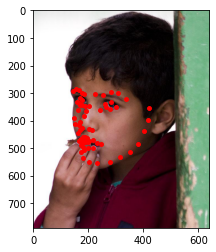

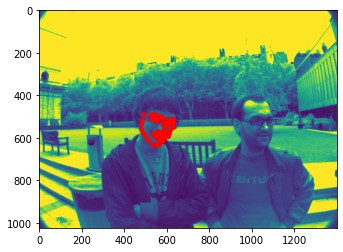

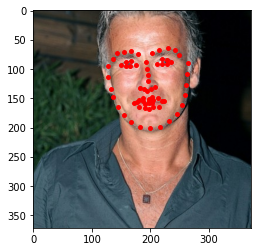

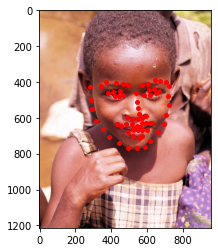

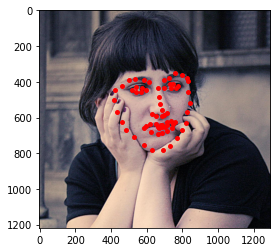

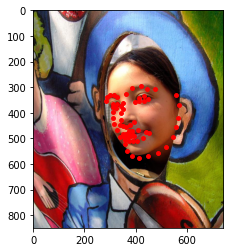

In [26]:
# visualize some images in test dataset with the prediction
with torch.no_grad():
  resnet18.eval()
  for sample_batched in test_dataloader:
    x = sample_batched["image"].to(device)
    x = x.unsqueeze(1)
    pred = resnet18(x)
    pred = torch.reshape(pred, (pred.shape[0], 68, 2))
    for j in range(6):
      landmarks_pred = pred.cpu().detach()[j]
      plt.figure()
      plt.imshow(sample_batched["image"][j], cmap="gray")
      plt.scatter(landmarks_pred[:, 0] * 224, landmarks_pred[:, 1] * 224, s = 15, c="red")
      plt.savefig("/test_img_cropped_{}.jpg".format(j + 1))
      plt.close()
      # plot prediction keypoints on original image
      landmarks_origin = (landmarks_pred * 224).numpy()
      box = sample_batched["box"][j]
      im_origin = skio.imread(img_filenames[j])
      left = max(0, int(box[0]))
      top = max(0, int(box[1]))
      width = int(box[2])
      height = int(box[3])

      landmarks_origin[:, 0] *= width / 224
      landmarks_origin[:, 1] *= height / 224

      landmarks_origin += [left, top]
      plt.figure()
      plt.imshow(im_origin)
      plt.scatter(landmarks_origin[:, 0], landmarks_origin[:, 1], s = 15, c="red")
      plt.savefig("/test_img_origin_{}.jpg".format(j + 1))

      
    break

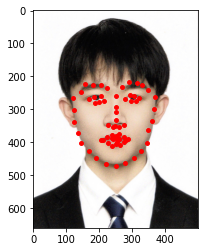

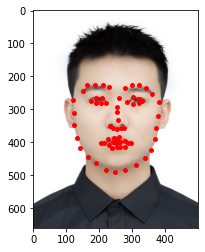

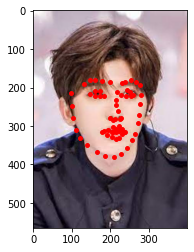

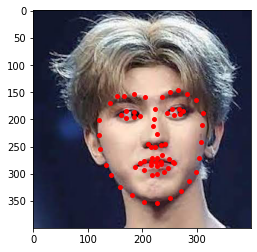

In [27]:
# apply the model on some images in my own collection
my_img_filenames = ["/mypicture.jpg", "/myfriend.jpg", "/idol1.jpg", "/idol2.jpg"]
bboxes = np.array([[120., 190., 250., 290.], [120., 180., 260., 300.], [100., 130., 200., 240.], [110., 100., 210., 250.]]).astype(np.float32)

# crop and resize the images in my dataset
ts = transforms.Compose([CroppingTest(), ResizeTest(224, 224), NormalizeTest()])
my_dataset = FaceKeypointTestDataset(my_img_filenames, bboxes, transform=ts)
# create dataloaders, using batch size of 4
BATCH_SIZE = 4
my_dataloader = DataLoader(my_dataset, batch_size=BATCH_SIZE, shuffle = False)

with torch.no_grad():
  resnet18.eval()
  for sample_batched in my_dataloader:
    x = sample_batched["image"].to(device)
    x = x.unsqueeze(1)
    pred = resnet18(x)
    pred = torch.reshape(pred, (pred.shape[0], 68, 2))
    for j in range(pred.shape[0]):
      landmarks_pred = pred.cpu().detach()[j]
      plt.figure()
      plt.imshow(sample_batched["image"][j], cmap="gray")
      plt.scatter(landmarks_pred[:, 0] * 224, landmarks_pred[:, 1] * 224, s = 15, c="red")
      plt.savefig("/my_img_cropped_{}.jpg".format(j + 1))
      plt.close()
      # plot prediction keypoints on original image
      landmarks_origin = (landmarks_pred * 224).numpy()
      box = sample_batched["box"][j]
      im_origin = skio.imread(my_img_filenames[j])
      left = max(0, int(box[0]))
      top = max(0, int(box[1]))
      width = int(box[2])
      height = int(box[3])

      landmarks_origin[:, 0] *= width / 224
      landmarks_origin[:, 1] *= height / 224

      landmarks_origin += [left, top]
      plt.figure()
      plt.imshow(im_origin)
      plt.scatter(landmarks_origin[:, 0], landmarks_origin[:, 1], s = 15, c="red")
      plt.savefig("/my_img_origin_{}.jpg".format(j + 1))

In [21]:
# for kaggle submission: create prediction list
pred_list = []
with torch.no_grad():
  resnet18.eval()
  for sample_batched in test_dataloader:
    x = sample_batched["image"].to(device)
    x = x.unsqueeze(1)
    pred = resnet18(x)
    pred = torch.reshape(pred, (pred.shape[0], 68, 2))
    for j in range(pred.shape[0]):
      landmarks_pred = pred.cpu().detach()[j]
      # compute the absolute landmarks in original image
      landmarks_origin = (landmarks_pred * 224).numpy()
      box = sample_batched["box"][j]
      left = max(0, int(box[0]))
      top = max(0, int(box[1]))
      width = int(box[2])
      height = int(box[3])

      landmarks_origin[:, 0] *= width / 224
      landmarks_origin[:, 1] *= height / 224

      landmarks_origin += [left, top]

      for row in landmarks_origin:
        pred_list.append(row[0])
        pred_list.append(row[1])


In [22]:
# for kaggle submission: create prediction list: create csv file with pandas
import pandas as pd
predictions = np.array(pred_list)
df = pd.DataFrame({'Predicted': predictions})
df.to_csv('submission.csv', index_label='Id')